# Random Forest Classification

In [1]:
import shap
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
os.environ['USE_PYGEOS'] = '0'

import geopandas as gpd
import trackintel as ti

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score
from sklearn.inspection import permutation_importance
from sklearn.base import clone


import matplotlib.pyplot as plt
import matplotlib.colors as clr

In [2]:
FEATURES_COL = [
    "length",
    "dur",
    "speed_av",
    "speed_85th",
    # "speed_90th",
    # "speed_95th",
    "acc_av",
    "acc_85th",
    "br_av",
    "br_85th",
    "rwStation_se_dist_min",
    "rwStation_se_dist_max",
    "tramStop_se_dist_min",
    "tramStop_se_dist_max",
    "busStop_se_dist_min",
    "busStop_se_dist_max",
    "carParking_se_dist_min",
    "carParking_se_dist_max",
    "bicycleParking_se_dist_min",
    "bicycleParking_se_dist_max",
    "landingStage_se_dist_min",
    "landingStage_se_dist_max",
    "rwStations_dist_av",
    "tramStops_dist_av",
    "busStops_dist_av",
    "poi_dist_av",
    "rwNetwork_dist_av",
    "tramNetwork_dist_av",
    "roadNetwork_dist_av",
    "pbNetwork_dist_av",
    "water_ovlp_prop",
    'greenSpaces_poly_dist', 
    'residental_poly_dist', 
    'forest_poly_dist'
]

FEATURES_SIMBOL = [
    "1.1 $D$",
    "1.2 $T$",
    "1.3 $\overline{V}$",
    "1.4 $V^{85^{th}}$",
    # "1.4 $V^{90^{th}}$",
    # "1.4 $V^{95^{th}}$",
    "1.5 $\overline{A}$",
    "1.6 $A^{85^{th}}$",
    "1.7 $\overline{B}$",
    "1.8 $B^{85^{th}}$",
    "2.1 $D^{min}_{rail}$",
    "2.2 $D^{max}_{rail}$",
    "2.3 $D^{min}_{tram}$",
    "2.4 $D^{max}_{tram}$",
    "2.5 $D^{min}_{bus}$",
    "2.6 $D^{max}_{bus}$",
    "2.7 $D^{min}_{car}$",
    "2.8 $D^{max}_{car}$",
    "2.9 $D^{min}_{bike}$",
    "2.10 $D^{max}_{bike}$",
    "2.11 $D^{min}_{ship}$",
    "2.12 $D^{max}_{ship}$",
    "2.13 $D_{railS}$",
    "2.14 $D_{tramS}$",
    "2.15 $D_{busS}$",
    "2.16 $D_{POIS}$",
    "2.17 $D_{railN}$",
    "2.18 $D_{tramN}$",
    "2.19 $D_{roadN}$",
    "2.20 $D_{pedN}$",
    "2.21 $P_{water}$",
    "2.22 $D_{green}$",
    "2.23 $D_{resident}$",
    "2.24 $D_{forest}$",
]

## Load Data

In [3]:
# load data
tl = pd.read_csv(os.path.join("data", "triplegs_features.csv"), index_col="index")
tl_data = tl[FEATURES_COL].copy()
X = tl_data

## Prepare Data for Classification

In [4]:
# prepare target for classification
tl_target = tl['mode'].replace({
    'Mode::Car': 'Car',
    'Mode::Ecar': 'Car',
    'Mode::Bicycle': 'Bicycle',
    'Mode::Ebicycle': 'Bicycle',
    'Mode::Walk': 'Walk',
    'Mode::Train': 'Train',
    'Mode::Tram': 'Tram',
    'Mode::Bus': 'Bus',
    'Mode::Boat': 'Boat'
})
y = tl_target

print('classes:', y.unique())
print('Dimensons of X:', X.shape)
print('Dimensons of y:', y.shape)

classes: ['Walk' 'Car' 'Train' 'Bicycle' 'Boat' 'Bus' 'Tram']
Dimensons of X: (365307, 32)
Dimensons of y: (365307,)


In [5]:
# split data into test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

In [6]:
y_train.value_counts()

Walk       124068
Car        104557
Train       41222
Bicycle      9587
Bus          7533
Tram         4991
Boat          287
Name: mode, dtype: int64

## Select Optimal Parameters

In [ ]:
def hyper_tune(X_train, y_train):
    # create random forest calssifier model
    rf_base = RandomForestClassifier(random_state=56, n_jobs=-1)

    # tuning hyper parameters with randomized search to optimize F1 score
    param_grid = {
        "n_estimators": np.arange(50, 301, 10),
        "max_depth": np.arange(10, 31, 2),
        "class_weight": [None, "balanced_subsample"],
    }
    n_iter_search = 200
    search = RandomizedSearchCV(
        rf_base, verbose=0, param_distributions=param_grid, n_iter=n_iter_search, scoring="f1_macro", n_jobs=-1
    )
    search.fit(X_train, y_train)
    print("Parameters:", search.best_params_)
    print("F1 Score:", search.best_score_)
    print(pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False))

hyper_tune(X_train, y_train)

## RF with the optimal parameter set

In [7]:
# create and fit random forest calssifier model
rf = RandomForestClassifier(
    n_estimators=150, max_depth=21, class_weight='balanced_subsample', random_state=10, n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       n_estimators=150, n_jobs=-1, random_state=10)

### Evaluate Model

Accuracy: 93.0 Average F1 score: 83.1
Bicycle: F1 score: 54.8 Recall: 50.4 Precision: 60.1
Boat: F1 score: 77.7 Recall: 76.2 Precision: 79.2
Bus: F1 score: 65.9 Recall: 62.5 Precision: 69.8
Car: F1 score: 92.7 Recall: 91.8 Precision: 93.7
Train: F1 score: 99.4 Recall: 99.2 Precision: 99.6
Tram: F1 score: 96.2 Recall: 94.0 Precision: 98.6
Walk: F1 score: 95.2 Recall: 97.0 Precision: 93.4


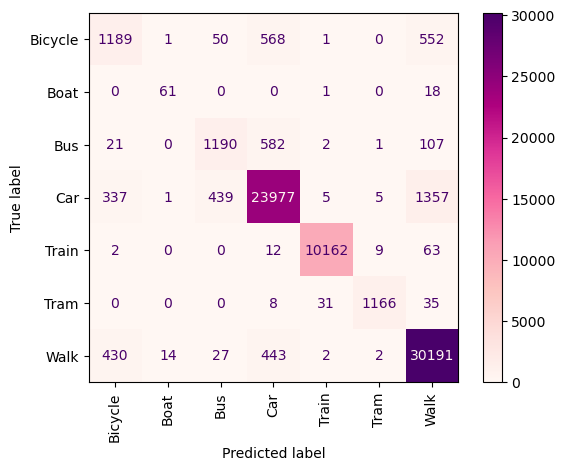

In [8]:
def evaluate_model(rf, X, y, print_metrics=True, cmap=plt.cm.RdPu):
    """calcualte evaluation metrics and displays confusion matrix"""

    # accuracy
    accuracy = rf.score(X, y)

    # average F1 score
    y_true = y
    y_pred = rf.predict(X)
    f1_av = f1_score(y_true, y_pred, average="macro")

    # F1 score for each class
    f1 = f1_score(y_true, y_pred, average=None)

    recall = recall_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average=None)

    if print_metrics:
        # print metrics
        print("Accuracy: {:.1f} Average F1 score: {:.1f}".format(accuracy * 100, f1_av * 100))
        for x in list(zip(rf.classes_, f1, recall, precision)):
            print(
                "{}: F1 score: {:.1f} Recall: {:.1f} Precision: {:.1f}".format(x[0], x[1] * 100, x[2] * 100, x[3] * 100)
            )

        # display confusion matrix
        ConfusionMatrixDisplay.from_estimator(rf, X, y, cmap=cmap, values_format="")  # Blues
        plt.xticks(rotation="vertical")
        plt.show()

    return accuracy, f1_av, f1

y_pred = rf.predict(X_test)
accuracy, f1_av, f1 = evaluate_model(rf, X_test, y_test)

## Feature Importance Evaluation

### Mean Decrease in Impurity

In [15]:
# MDI importance
result_mdi = rf.feature_importances_
result_mdi_std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

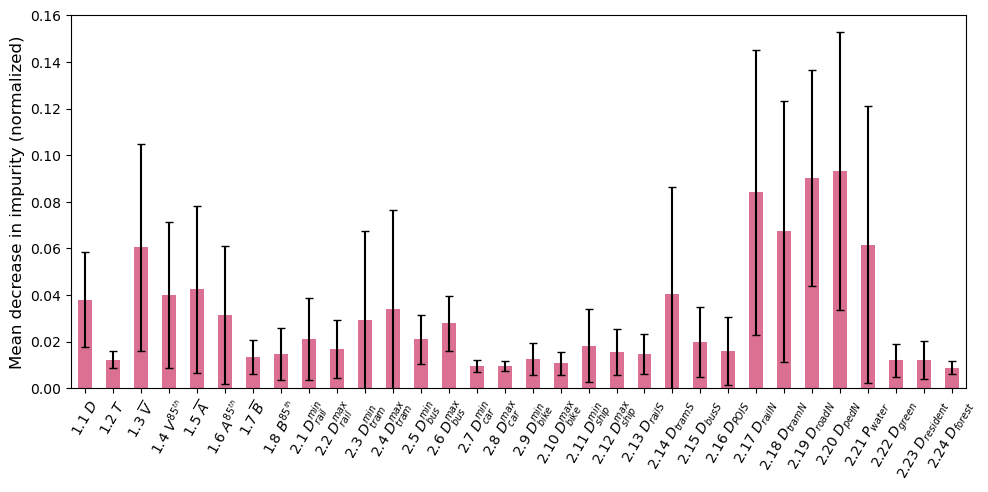

In [16]:
# error bars show inter-tree variability
forest_importances = pd.Series(result_mdi, FEATURES_SIMBOL)

fig, ax = plt.subplots(figsize=(10,5))
forest_importances.plot.bar(color='palevioletred', yerr=result_mdi_std, ax=ax, capsize=3, rot=60)
ax.set_ylabel("Mean decrease in impurity (normalized)", fontsize=12)
fig.tight_layout()

plt.ylim([0, 0.16])

plt.savefig(os.path.join("fig", "MDI.png"), bbox_inches="tight", dpi=600)
plt.show()

### Feature Permutation Importance

In [17]:
# permutation_importance
result_permutation = permutation_importance(
    rf, X_test, y_test, n_repeats=5, scoring="f1_macro", random_state=56, n_jobs=-1
)
permutation_importances = pd.Series(result_permutation.importances_mean, index=FEATURES_SIMBOL)

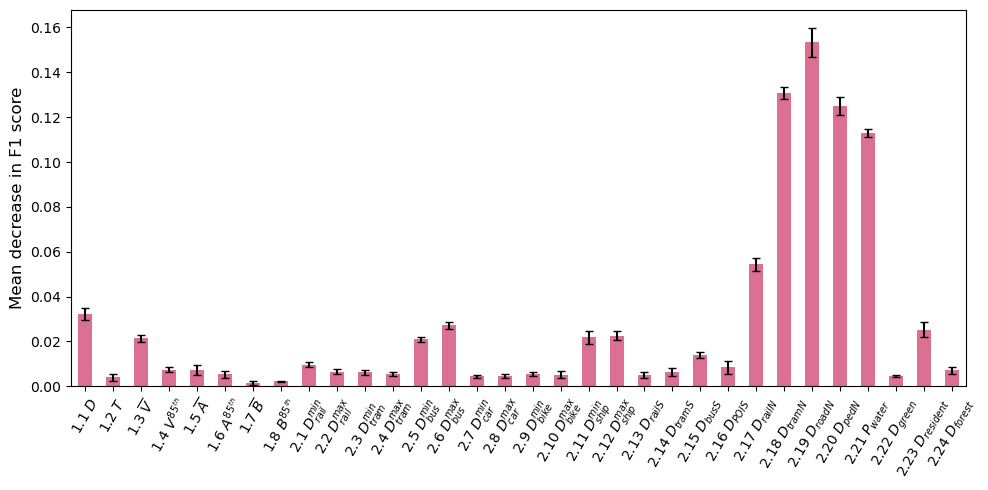

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
permutation_importances.plot.bar(
    color="palevioletred", yerr=result_permutation.importances_std, ax=ax, capsize=3, rot=60
)

ax.set_ylabel("Mean decrease in F1 score", fontsize=12)
fig.tight_layout()
ax.set_axisbelow(True)

plt.savefig(os.path.join("fig", "permutation.png"), bbox_inches="tight", dpi=600)
plt.show()

### Drop Column Importance

In [19]:
def _drop_col_feat_imp(model, X_train, y_train, X_test, y_test, benchmark_score, random_state = 56):        
    '''Calculate drop column importance for every feature in X'''
    # list for storing feature importances
    importances = []
    # iterate over all columns and calculate feature importance (difference between benchmark and new model)
    for col in tqdm(X_train.columns):
        # clone model
        model_clone = clone(model)
        model_clone.random_state = random_state
        # drop column and re-train model
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        y_test_pred = model_clone.predict(X_test.drop(col, axis=1))
        # compare score to benchmark score
        drop_col_score = f1_score(y_test, y_test_pred, average='macro')
        importances.append(benchmark_score - drop_col_score)
        
    return importances

# drop column importances
res = []

for i in range(5):
    result_dropColumn = _drop_col_feat_imp(
        rf, X_train, y_train, X_test, y_test, random_state=i, benchmark_score=f1_av
    )
    res.append(result_dropColumn)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [21:15<00:00, 39.87s/it]


In [ ]:
drop_importance = pd.Series(np.mean(res, axis=0), index=FEATURES_SIMBOL)

fig, ax = plt.subplots(figsize=(10,6))
drop_importance.plot.bar(color='palevioletred', yerr=np.std(res, axis=0), ax=ax,capsize=3, rot=60)
ax.set_ylabel("Mean decrease in F1-score", fontsize=12)
fig.tight_layout()
plt.yticks(np.arange(-0.003, 0.016, 0.003))


plt.savefig(os.path.join("fig", "drop.png"), bbox_inches="tight", dpi=600)

plt.show()

### SHAP Feature Importance

In [9]:
classes = rf.classes_.tolist()
explainer = shap.explainers.Tree(rf, feature_perturbation="tree_path_dependent")

In [10]:
shap_values = explainer.shap_values(X_test, approximate=True)

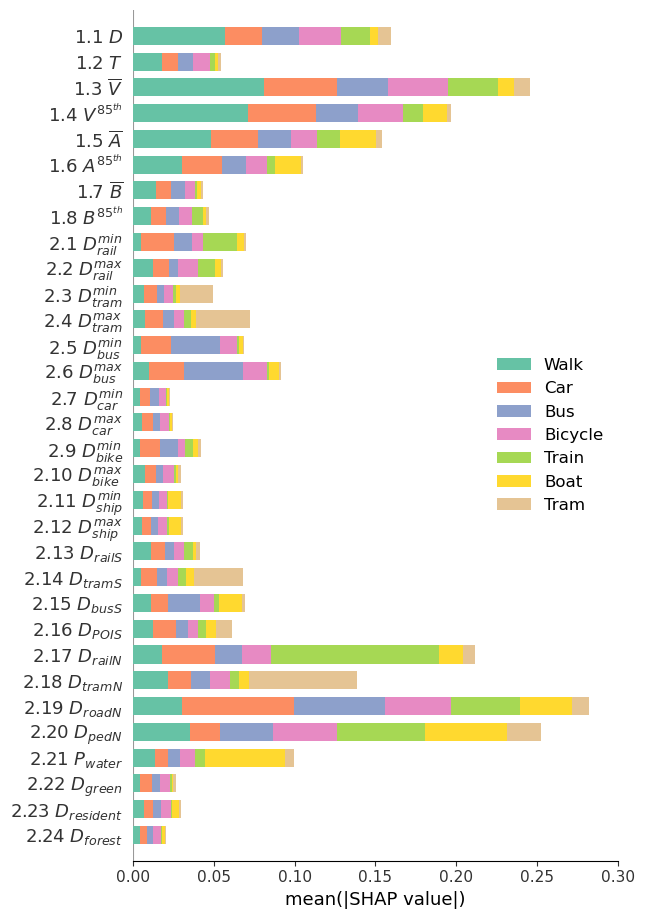

In [11]:
fig = plt.figure()

# visualize shap summary plot of mean importance
shap.summary_plot(shap_values, feature_names=FEATURES_SIMBOL, class_names=classes, plot_type="bar", color=plt.get_cmap("Set2"), sort=False, max_display=36, show = False)
# shap.summary_plot(overall_shap_values, feature_names=FEATURES_SIMBOL, color='palevioletred', sort=False, plot_type="bar", max_display=32, show = False)

plt.gcf().set_size_inches(6,9)
plt.xlabel("mean(|SHAP value|)")
plt.xlim([0,0.3])

plt.savefig(os.path.join("fig", "shap.png"), bbox_inches='tight', dpi=600)

plt.show()

In [12]:
classes_dict = {
    "Bicycle": 3,
    'Boat':5, 
    'Bus': 2, 
    'Car': 1, 
    'Train':4, 
    'Tram':6, 
    'Walk':0, 
}
classes_dict_ivt = {v: k for k, v in classes_dict.items()}

Summary Plot for Class Walk


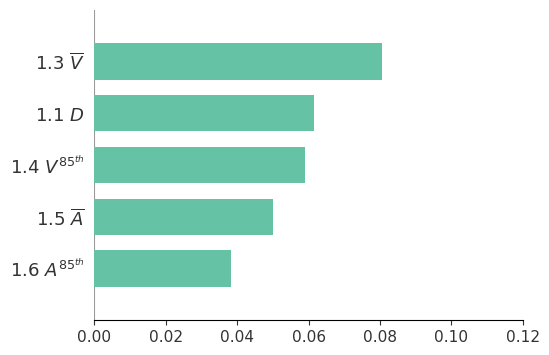

Summary Plot for Class Car


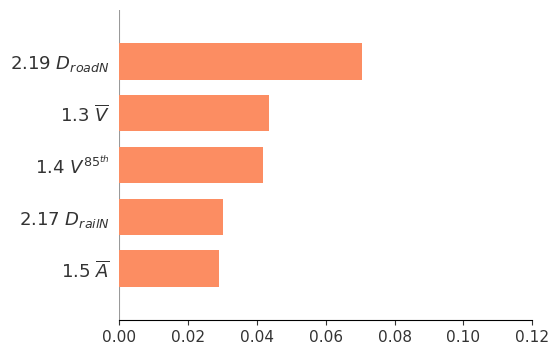

Summary Plot for Class Bus


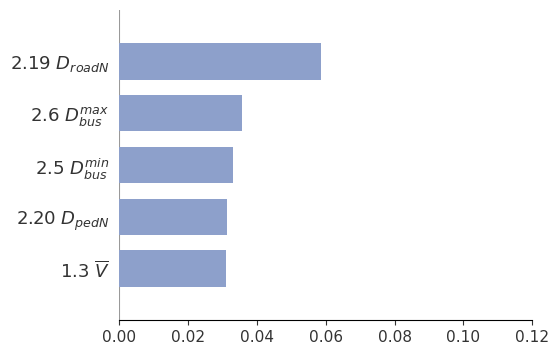

Summary Plot for Class Bicycle


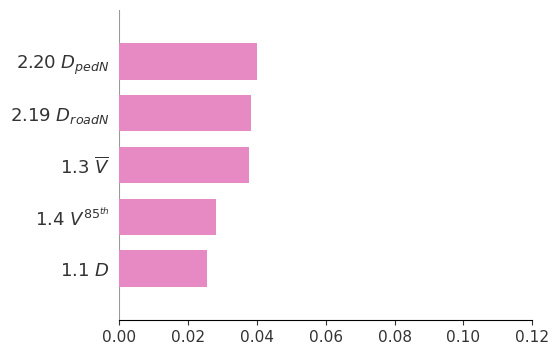

Summary Plot for Class Train


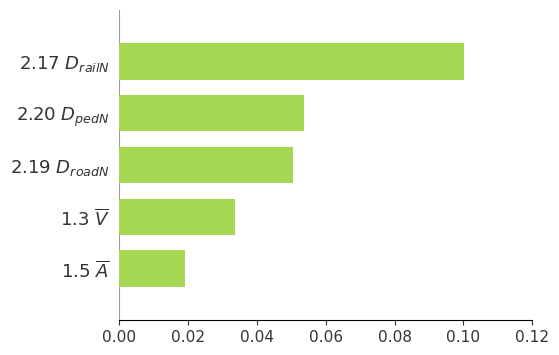

Summary Plot for Class Boat


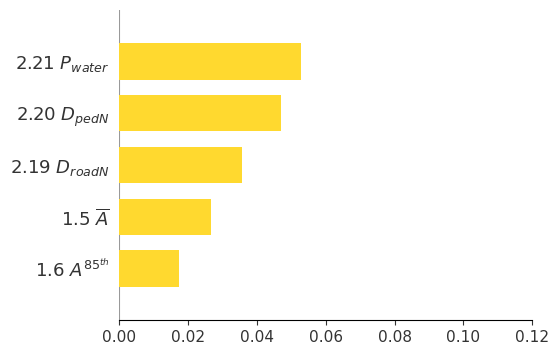

Summary Plot for Class Tram


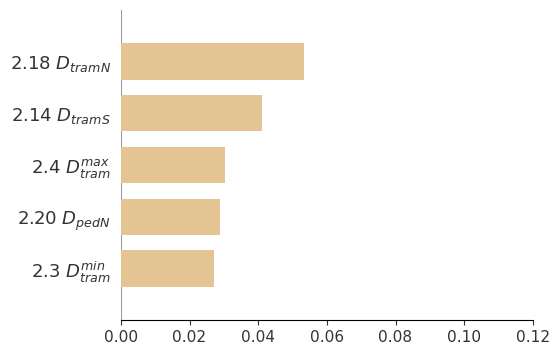

In [13]:
# SHAP summary plot by class

colors = iter([plt.cm.Set2(i) for i in range(20)])

for i in range(7):
    fig = plt.figure()
    print('Summary Plot for Class', classes_dict_ivt[i])
    shap.summary_plot(shap_values[classes.index(classes_dict_ivt[i])], X_test.values, feature_names=FEATURES_SIMBOL, plot_type="bar", color=next(colors), max_display=5, show = False)
    plt.xlim([0,0.12])
    plt.gcf().set_size_inches(5,4)
    plt.xlabel("")
    plt.savefig(os.path.join("fig", f"shap_{i}_{classes_dict_ivt[i]}.png"), bbox_inches='tight', dpi=600)
    plt.show()